# 線形回帰（複数パラメータ）に対するラプラス近似

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

In [39]:
function log_joint(w, X, Y, σ, μ₁, σ₁, μ₂, σ₂)
    sum(logpdf.(Normal.(w[1] * X .+ w[2], σ), Y)) + 
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2])
end

function ulp(w)
    log_joint(w, params...)
end

ulp (generic function with 2 methods)

In [40]:
function gradient_method(f, x_init, η, maxiter)
    x_seq = Array{typeof(x_init[1]), 2}(undef, length(x_init), maxiter)
    ∇f(x) = ForwardDiff.gradient(f, x)
    x_seq[:, 1] = x_init
    for i in 2:maxiter
        x_seq[:, i] = x_seq[:, i-1] + η * ∇f(x_seq[:, i-1])
    end
    return x_seq
end

gradient_method (generic function with 1 method)

In [44]:
function calc_approx_params(w_seq)
    μ_approx = w_seq[:, end]
    
    hessian(w) = ForwardDiff.hessian(ulp, w)
    Σ_approx = inv(-hessian(μ_approx))
    
    return μ_approx, Σ_approx
end

calc_approx_params (generic function with 1 method)

In [45]:
function learn_laplace(w_init, η, maxiter)
    w_seq =　gradient_method(ulp, w_init, η, maxiter)
    μ_approx, Σ_approx = calc_approx_params(w_seq)
    return μ_approx, Σ_approx
end

learn_laplace (generic function with 1 method)

In [50]:
function p_predictive(μ_approx, Σ_approx, x, y)
    w₁s = w₂s = range(-5, 5, length=100)
    Δ₁ = w₁s[2] - w₁s[1]
    Δ₂ = w₂s[2] - w₂s[1]
    density_y = sum([pdf(Normal(w₁ * x + w₂, σ), y) *
                     pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) *
                     Δ₁ * Δ₂ for w₁ in w₁s, w₂ in w₂s])
    return density_y
end

p_predictive (generic function with 1 method)

In [51]:
function vialize_2D(μ_approx, Σ_approx)
    w₁s = w₂s = range(-5, 5, length=100)
    p = contour(w₁s, w₂s, [pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) for w₁ in w₁s, w₂ in w₂s]',
        lab="w₁", ylab="w₂", title="approximate posterior", label=:none)
    return p
end

vialize_2D (generic function with 2 methods)

In [52]:
# 観測データ
X_obs = [
    -2.0
    1.0
    5.0
]

Y_obs = [
    -2.2
    -1.0
    1.5
]

# 事前分布のパラメータを設定
σ = 1.0
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0

params = (X_obs, Y_obs, σ, μ₁, σ₁, μ₂, σ₂)

w_init = [0.0, 0.0]
maxiter = 1000
η = 0.01

μ_approx, Σ_approx = learn_laplace(w_init, η, maxiter)

xs = range(-10, 10, length=100)
ys = range(-5, 5, length=100)
density_y = p_predictive.(μ_approx, Σ_approx, xs, ys');

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 2 and 100")

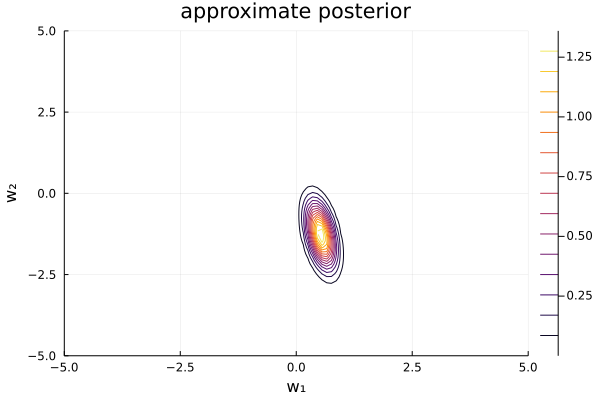